## SAM(Segment Anything Model) 실습

https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb

Reference: [original Segment-Anything github](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb)

- it was tested in MLP-suwon P40 [O]

In [ ]:
# !pip install -q transformers

In [1]:
import sys  # 'linux', 'win32'
import os #'nt','posix'
if sys.platform == 'linux': # mlp
    # in order to download models from huggingface in the ML Platform, it is necessary to set the following proxy and ssl 
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
    # suwon
    import os
    os.environ['REQUESTS_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'
    os.environ['HTTP_PROXY'] ='http://75.17.107.42:8080'
    os.environ['HTTPS_PROXY'] ='http://75.17.107.42:8080'
elif sys.platform == 'win32':
    os.environ["PATH"]+= os.pathsep+"C:/Program Files/Graphviz/bin"

In [2]:
import os
cache_path = 'd:/HF_cache'
os.environ['HF_HOME'] = cache_path
os.environ['TRANSFORMERS_CACHE'] = cache_path # seems not to work

### Utility functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
        masks = masks.squeeze()
    if scores.shape[0] == 1:
        scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask = mask.cpu().detach()
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
        axes[i].axis("off")
    plt.show()

### SAM processing flow
(input(image, points, boxes, labels)) &rarr; SamProcessor &rarr; (inputs:dict + image_embeddings)   
&rarr; SamModel &rarr; (output(masks))   
&rarr; SamProcessor.post_process_masks &rarr; visualization 

- image embedding은 한번 해서 반복적으로 사용
  * image_embeddings = model(SamModel).get_image_embeddings(inputs["pixel_values"])
- 참조: [SamModel](https://huggingface.co/docs/transformers/v4.43.2/en/model_doc/sam#transformers.SamModel), 
  [SamImageProcessor](https://huggingface.co/docs/transformers/v4.43.2/en/model_doc/sam#transformers.SamImageProcessor)

### Model loading

- facebook의 sam-vit-huge pre-trained 모델 loading

In [6]:
import torch
import torchvision
# disable warning message
torchvision.disable_beta_transforms_warning()

from transformers import SamModel, SamProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge", cache_dir=cache_path).to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge", cache_dir=cache_path)

In [7]:
#dataset_path = '/group-volume/sr_edu/AI-Application-Specialist-Vision-Dataset/hf-assets/'
dataset_path = 'z:/AI-Application-Specialist-Vision-Dataset/hf-assets/'

### Run predictions

### Load the example image

(-0.5, 2645.5, 1763.5, -0.5)

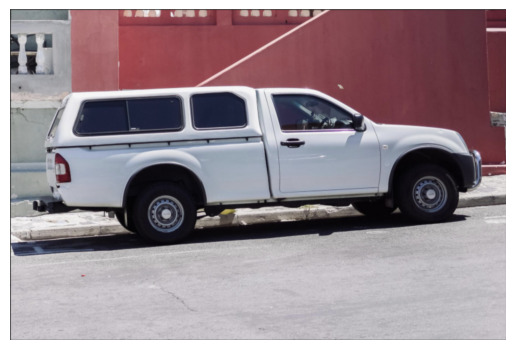

In [8]:
from PIL import Image
import requests

download_url = True

# 최근 mlp에서 block
if download_url == True:
    img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
else:
    img_file = dataset_path  + "car.png"
    raw_image = Image.open(img_file).convert("RGB")

plt.imshow(raw_image)
plt.axis('off')

In [9]:
raw_image.size

(2646, 1764)

#### Step 1: Retrieve the image embeddings

In [10]:
# return_tensors="pt": return tensor.Tensor. (If "tf", returns tf.Tensor)
# - https://huggingface.co/docs/transformers/model_doc/sam
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

In [11]:
inputs.keys(), inputs['pixel_values'].shape, inputs['reshaped_input_sizes'], image_embeddings.shape, 1024/2646*1764
#  reshaped_input_size: masking 처리를 위한 (1024로 입력 영상 크기로 resize시) 1024x1024에서 원영상의 크기 정보
#   예) original image size: 2646x1764
#       모델 입력 image size: 1024x1024 (1024x683 영역이 original image의 영역, 나머지는 padding)
#       683 = 1024/2646 * 1764

(dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes']),
 torch.Size([1, 3, 1024, 1024]),
 tensor([[ 683, 1024]], device='cuda:0'),
 torch.Size([1, 256, 64, 64]),
 682.6666666666666)

## Usecase 1: Feed a set of 2D points to predict a mask

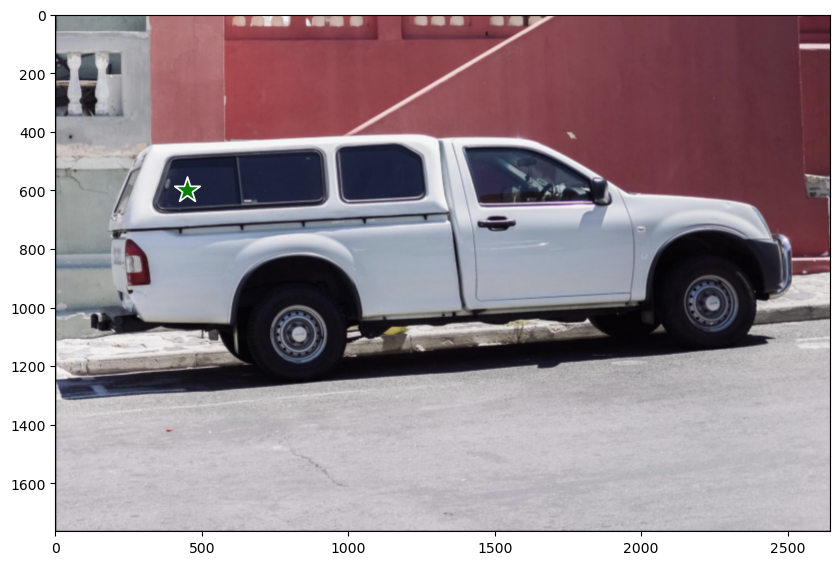

In [12]:
# a single point
input_points = [[[450, 600]]] # batch x points x point(x, y)
show_points_on_image(raw_image, input_points[0])
#plt.axis('off')

See image_processor.post_process_masks: [API manual](https://huggingface.co/docs/transformers/v4.43.2/en/model_doc/sam#transformers.SamImageProcessor.post_process_masks), 
[code](https://github.com/huggingface/transformers/blob/v4.45.2/src/transformers/models/sam/image_processing_sam.py#L631)
- (pred_masks) &rarr; Bilinear Interpolation &rarr; (masks w/ reshaped_input_sizes)   
  &rarr; Bilinear Interpolation &rarr; (masks w/ original image size)  
  &rarr; Binarization &rarr; (binary masks)

In [13]:
inputs = processor(raw_image, input_points=input_points, 
                   return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)


masks = processor.image_processor.post_process_masks(
                                    outputs.pred_masks.cpu(),  
                                    inputs["original_sizes"].cpu(), 
                                    inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [14]:
inputs.keys()

dict_keys(['original_sizes', 'reshaped_input_sizes', 'input_points', 'image_embeddings'])

In [15]:
masks[0].shape, scores.shape

(torch.Size([1, 3, 1764, 2646]), torch.Size([1, 1, 3]))

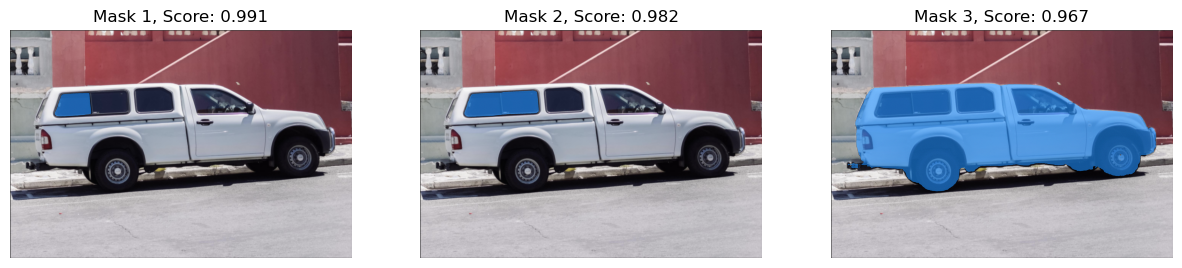

In [16]:
show_masks_on_image(raw_image, masks[0], scores)

In [17]:
outputs

SamImageSegmentationOutput(iou_scores=tensor([[[0.9910, 0.9818, 0.9667]]], device='cuda:0'), pred_masks=tensor([[[[[-21.9036, -24.0779, -24.5661,  ..., -24.9704, -21.1652,
            -27.4708],
           [-21.6857, -37.1744, -32.4305,  ..., -28.3308, -31.4499,
            -26.8422],
           [-20.9281, -29.3686, -26.0875,  ..., -25.6732, -22.7068,
            -27.0328],
           ...,
           [-32.9388, -42.9462, -36.2928,  ..., -31.5334, -28.7133,
            -26.8680],
           [-44.3891, -41.1805, -51.0143,  ..., -28.2070, -30.2413,
            -28.7217],
           [-32.5330, -43.5377, -34.7989,  ..., -28.1152, -26.8659,
            -24.4335]],

          [[-18.8842, -18.4583, -19.0108,  ..., -21.2492, -21.7450,
            -21.4314],
           [-18.0087, -26.5090, -21.7166,  ..., -22.4359, -22.1002,
            -22.4008],
           [-17.7044, -21.3969, -18.8217,  ..., -20.2116, -20.2069,
            -20.3435],
           ...,
           [-25.4007, -34.0195, -27.0846,  

### To predict a single mask using a set of points

- 두개 point 사용한 1 mask prediction

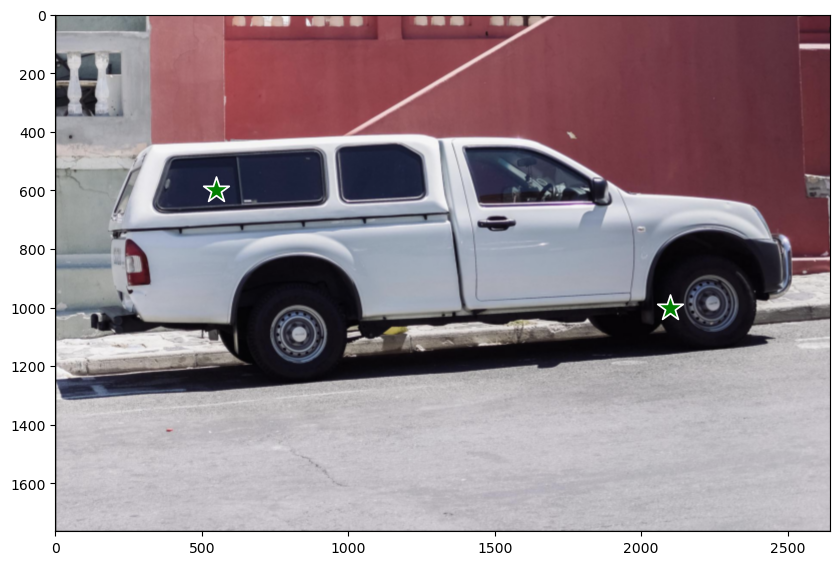

In [18]:
input_points = [[[550, 600], [2100, 1000]]]
show_points_on_image(raw_image, input_points)

In [19]:
inputs = processor(raw_image, input_points=input_points, 
                   return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
                                    outputs.pred_masks.cpu(), 
                                    inputs["original_sizes"].cpu(), 
                                    inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

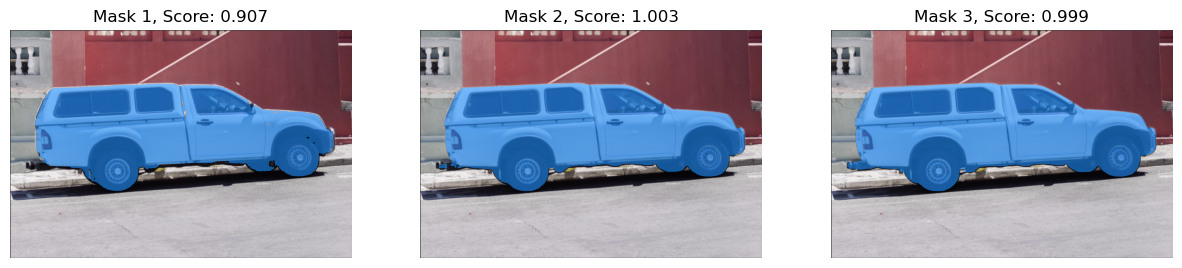

In [20]:
show_masks_on_image(raw_image, masks[0], scores)

## Usecase 2: Predict segmentations masks using bounding boxes

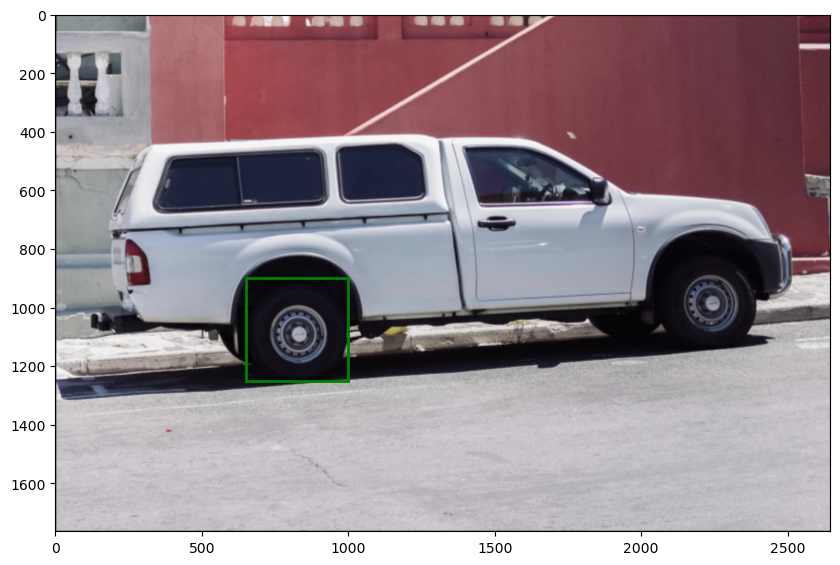

In [21]:
input_boxes = [[[650, 900, 1000, 1250]]]

show_boxes_on_image(raw_image, input_boxes[0]) 

In [22]:
inputs = processor(raw_image, input_boxes=[input_boxes], 
                   return_tensors="pt").to(device)
inputs["input_boxes"].shape

torch.Size([1, 1, 4])

In [23]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
                                    outputs.pred_masks.cpu(), 
                                    inputs["original_sizes"].cpu(), 
                                    inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

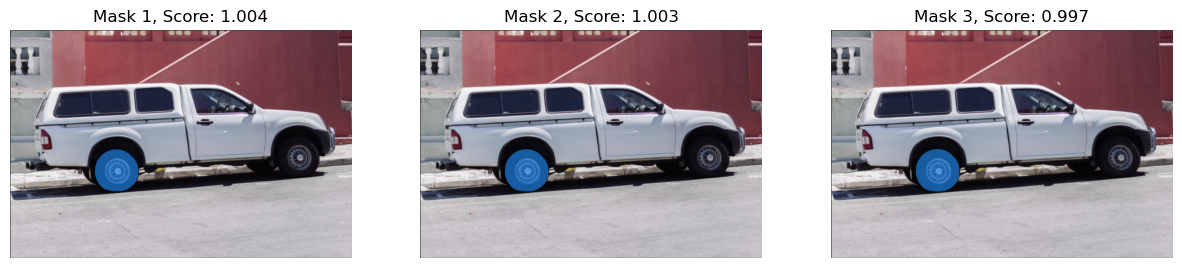

In [24]:
show_masks_on_image(raw_image, masks[0], scores)

## Usecase 3:Predict segmentation masks given points and bounding boxes

- box하나, point 하나에 대한 mask predction

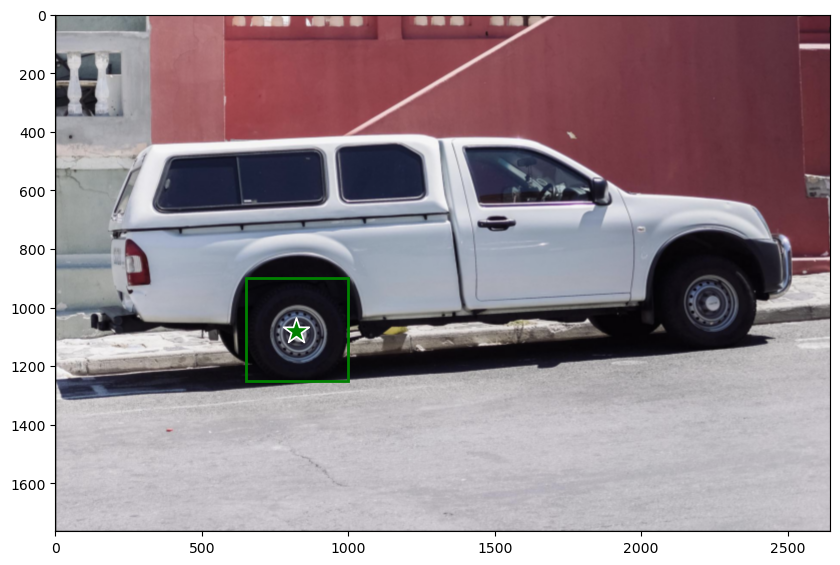

In [25]:
input_boxes = [[[650, 900, 1000, 1250]]]
input_points = [[[820, 1080]]]

show_points_and_boxes_on_image(raw_image, input_boxes[0], input_points[0])

In [26]:
inputs = processor(raw_image, input_boxes=[input_boxes], 
                   input_points=[input_points], return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
                                    outputs.pred_masks.cpu(), 
                                    inputs["original_sizes"].cpu(), 
                                    inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

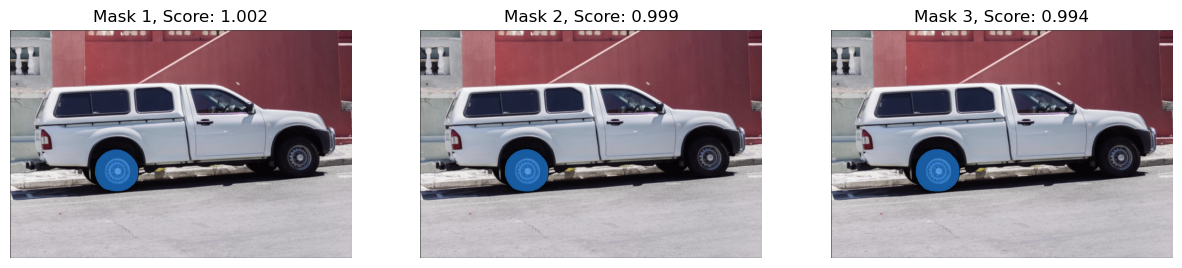

In [27]:
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

### point의 label 0(제외할 영역) 입력으로 제공하여 box 내에서 point 바깥 영역에 대한 semantic mask prediction

- 참조 : 3 label types
  * 1: the point is a point that contains the object of interest
  * 0: the point is a point that does not contain the object of interest
  * -1: the point corresponds to the background
  * [참조 link](https://huggingface.co/docs/transformers/model_doc/sam#transformers.SamModel.forward)

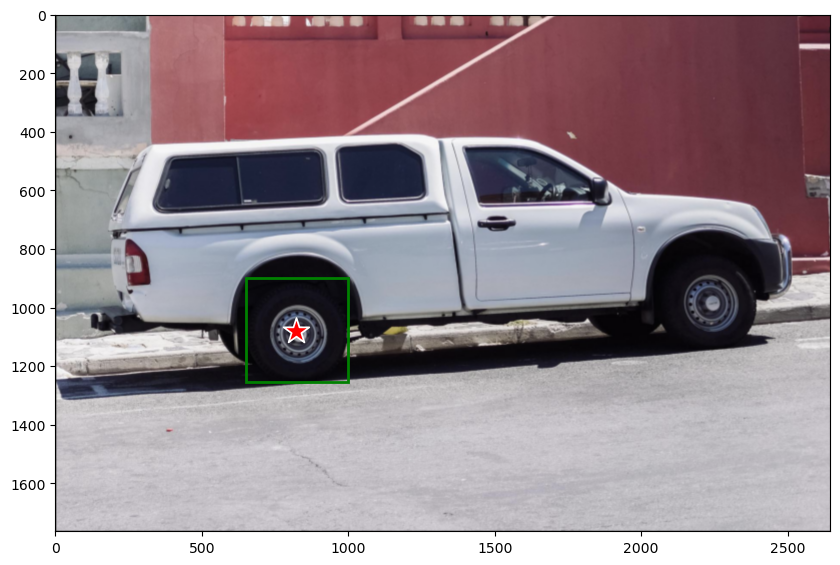

In [28]:
input_boxes = [[[650, 900, 1000, 1255]]]
input_points = [[[820, 1080]]]
labels = [0]

show_points_and_boxes_on_image(raw_image, input_boxes[0], input_points[0], labels)

In [29]:
input_boxes = [[[620, 900, 1000, 1255]]]
input_points = [[[820, 1080]]]
labels = [[0]]
inputs = processor(raw_image, input_boxes=[input_boxes], 
                   input_points=[input_points], input_labels=[labels], 
                   return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
                                    outputs.pred_masks.cpu(), 
                                    inputs["original_sizes"].cpu(), 
                                    inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

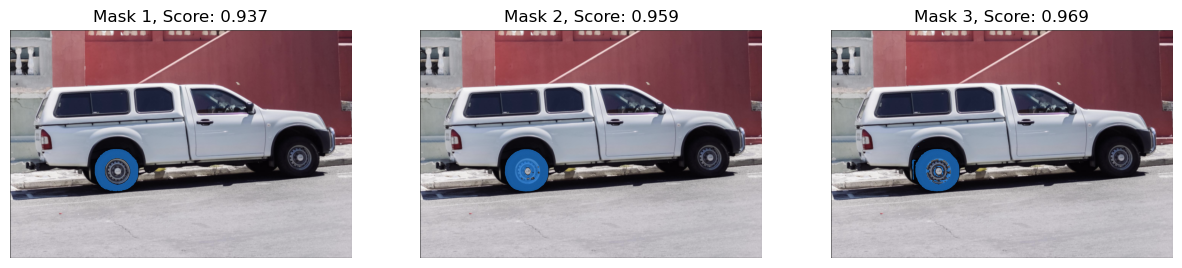

In [30]:
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

: 0으로 label된 point 지정 영역을 제외한 외부의 영역에 대한 mask가 찾아짐을 볼 수 있음 

## Usecase 4: Predict multiple masks per image

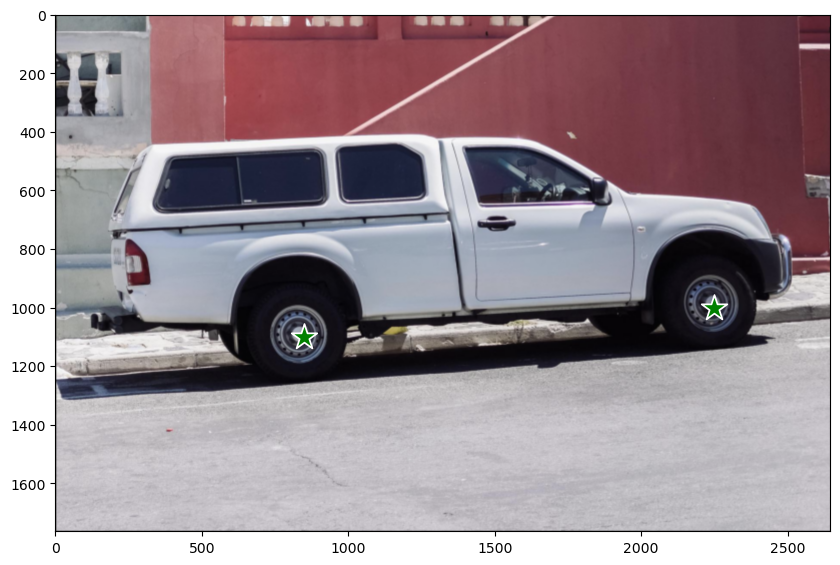

In [31]:
input_points = [[[850, 1100], [2250, 1000]]]
show_points_on_image(raw_image, input_points)

### Sub-usecase 1: one prediction per point

- 두개 point 입력: 각각에 대한 mask prections(두개)

In [32]:
input_points = [[[[850, 1100]], [[2250, 1000]]]]
inputs = processor(raw_image, input_points=input_points, 
                   return_tensors="pt").to(device)
inputs["input_points"].shape

torch.Size([1, 2, 1, 2])

In [33]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
                                    outputs.pred_masks.cpu(), 
                                    inputs["original_sizes"].cpu(), 
                                    inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [34]:
scores.shape, len(masks), masks[0].shape

(torch.Size([1, 2, 3]), 1, torch.Size([2, 3, 1764, 2646]))

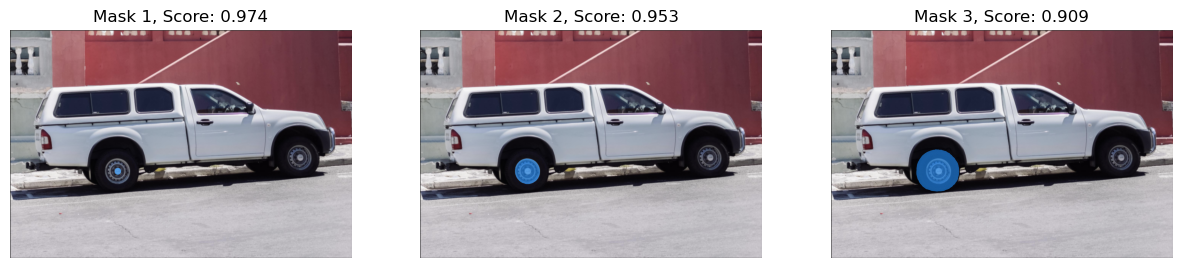

In [35]:
# 첫번째 point에 대한 predicted mask 및 score(3개)
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

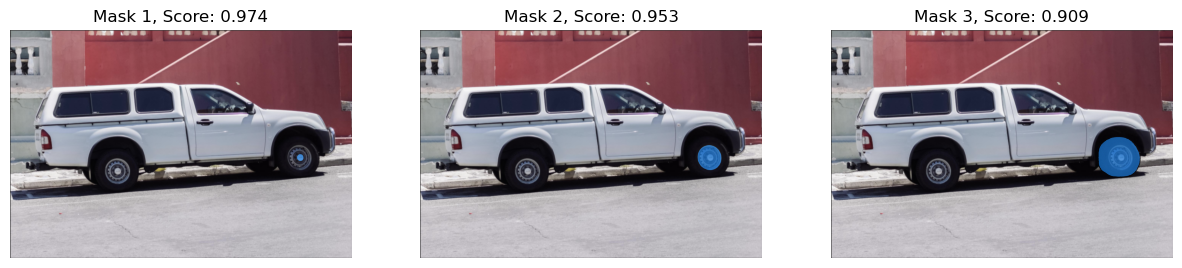

In [36]:
# 두번째 point에 대한 predicted mask 및 score(3개)
show_masks_on_image(raw_image, masks[0][1], scores[:, 0, :])

### Sub-usecase 2: Feed multiple bounding boxes to the same image

- 두개 box 입력: 각각에 대한 mask prediction

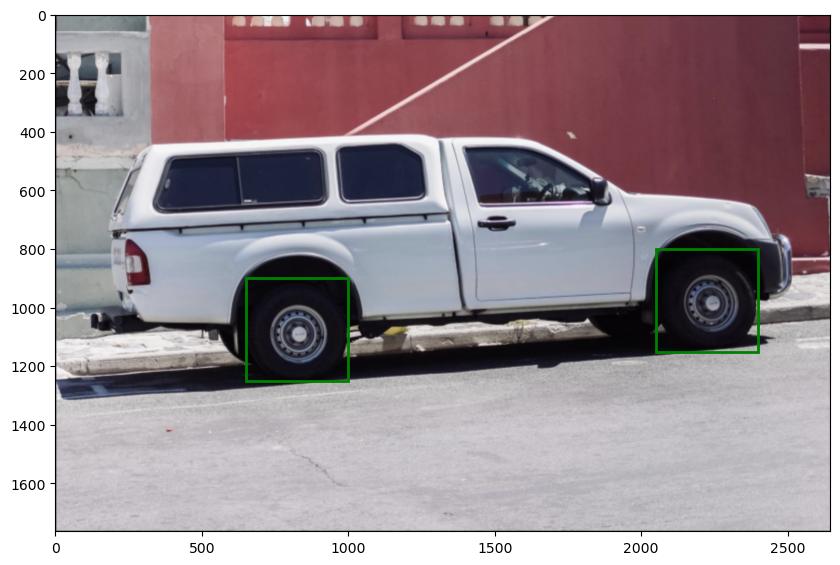

In [37]:
input_boxes = [[[650, 900, 1000, 1250], [2050, 800, 2400, 1150]]]

show_boxes_on_image(raw_image, input_boxes[0]) 

In [38]:
input_boxes = [[[650, 900, 1000, 1250], [2050, 800, 2400, 1150]]]
inputs = processor(raw_image, input_boxes=input_boxes, 
                   return_tensors="pt").to(device)
inputs["input_boxes"].shape

torch.Size([1, 2, 4])

In [39]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

masks = processor.image_processor.post_process_masks(
                                    outputs.pred_masks.cpu(), 
                                    inputs["original_sizes"].cpu(), 
                                    inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [40]:
scores.shape, len(masks), masks[0].shape

(torch.Size([1, 2, 1]), 1, torch.Size([2, 1, 1764, 2646]))

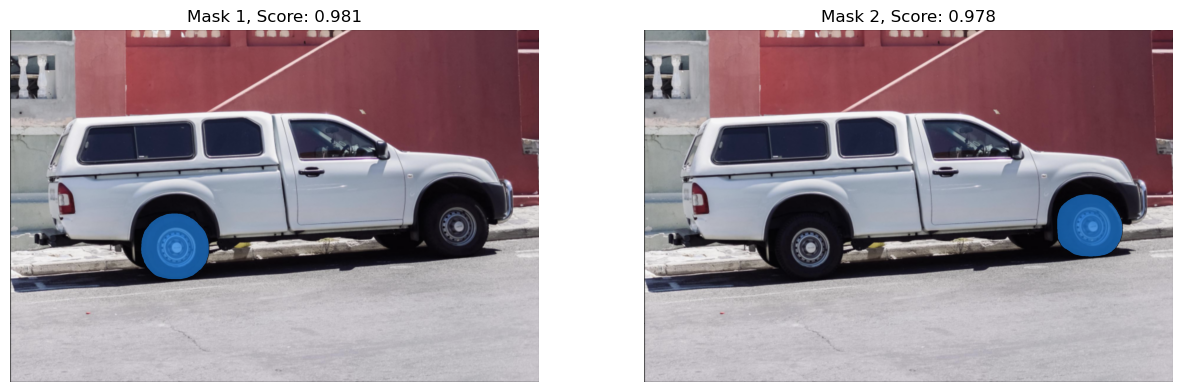

In [41]:
show_masks_on_image(raw_image, masks[0], scores)

### (ToDo) 3개 mask output을 다 보려면
- 참조: [SamModel](https://huggingface.co/docs/transformers/v4.43.2/en/model_doc/sam#transformers.SamModel)

In [ ]:
# code ... 


In [49]:
scores.shape, len(masks), masks[0].shape

(torch.Size([1, 2, 1]), 1, torch.Size([2, 1, 1764, 2646]))

In [50]:
show_masks_on_image(raw_image, masks[0][0,:,:,:], scores[0,0,:])

IndexError: tuple index out of range

In [51]:
show_masks_on_image(raw_image, masks[0][1,:,:,:], scores[0,1,:])

IndexError: tuple index out of range

In [56]:
scores[0,0,:].shape[-1]

1

In [58]:
len(masks)

1